<img src="./logo_UNSAM.jpg" align="right" width="150" />

# Tarea semanal 4 
### Análisis y procesamiento de señales
**Kala Ariadna Guevara, Carola Piazze Vicini**

## Introducción 

El objetivo de este trabajo fue diseñar y comparar distintos estimadores de amplitud y frecuencia de una señal senoidal en presencia de ruido gaussiano. Se evaluaron el sesgo, la varianza, la influencia de cada ventana sobre la precisión de los estimadores y la influencia de dos niveles distintos de SNR.

Un estimador es una función o procedimiento que permite obtener una **estimación** de un parámetro desconocido de un proceso estocástico a partir de datos observados.
Dado el parámetro verdadero $\theta$  y  un estimador $\hat{\theta}$, nos interesa particularmente analizar dos propiedades estadísticas: el sesgo (la diferencia entre el valor estimado medio y el valor real)  y la varianza (la dispersión de los valores estimados).
$$
\text{sesgo}(\hat{\theta}) = E[\hat{\theta}] - \theta
$$

$$
\text{var}(\hat{\theta}) = E[(\hat{\theta} - E[\hat{\theta}])^2]
$$

Un estimador ideal es insesgado y tiene mínima varianza, es decir que su valor esperado coincide con el valor real del parámetro y presenta baja dispersión entre realizaciones.

El diseño de los estimadores parte del periodograma, que consiste en multiplicar la señal por una ventana, calcular la transformada discreta de fourier y luego analizar la energía espectral resultante. 

#### Estimador de amplitud
La amplitud de una señal senoidal se puede estimar mediante el módulo del espectro de la señal en la frecuencia de interés:
$$
\hat{a}_1(i) = |X_{w_i}(\Omega_0)| = |\mathcal{F}\{x[n] \cdot w_i[n]\}|
$$
donde $w_i[n]$ es la ventana aplicada (rectangular, flattop, blackman harris, etc.), y $X_{w_i}(\Omega)$ es la transformada de Fourier de la señal ventaneada.

#### Estimador de frecuencia
La frecuencia estimada se obtiene  buscando el valor de frecuencia donde el módulo del espectro es máximo, ya que el procedimiento se basa en la idea de que la energía de una senoide se concentra en una frecuencia dominante.


$$
\hat{\Omega}_1(i) = \arg \max_{\Omega} |X_{w_i}(\Omega)|
$$
donde $X_{w_i}(\Omega)$ es la transformada de Fourier de la señal multiplicada por la ventana $w_i[n]$.

#### Ventaneo
El ventaneo en el dominio temporal permite reducir el efecto del spectral leakage. Cada ventana tiene una forma espectral característica, con un lóbulo principal (donde se concentra la energía real del tono) y varios lóbulos laterales (responsables del leakage).
El comportamiento de estos lóbulos define el compromiso entre resolución en frecuencia y la varianza.


**Rectangular:**
Tiene el lóbulo principal más angosto, lo que da la mejor resolución en frecuencia, los lóbulos laterales son altos ($\approx -13$ dB) por lo que presenta mayor leakage, especialmente si la frecuencia real no coincide exactamente con un bin de la FFT.

**Flattop:**
Está diseñada para medir amplitudes con muy bajo error, sus lóbulos laterales son muy atenuados ($\approx -93$ dB) y su lóbulo principal es ancho, por lo que la resolución en frecuencia es baja. Es ideal cuando el objetivo es estimar amplitud con precisión, no tanto frecuencia.

**Blackman–Harris:**
También tiene lóbulos laterales muy atenuados ($\approx -92$ dB), lo que disminuye notablemente el leakage respecto de la ventana rectangular. Su lóbulo principal es algo más angosto que el de la flattop, por lo que el compromiso es razonable  entre baja contaminación espectral y una resolución en frecuencia aceptable. Es una buena opción cuando se requiere un equilibrio entre estimar amplitud y frecuencia con buena precisión.

**Hann:**
Sus lóbulos laterales son en torno a −31 dB, más atenuados que los de la ventana rectangular, y un lóbulo principal de ancho moderado. El compromiso es equilibrado: mejora lel spectral leakage respecto a la rectangular, pero sin ensanchar tanto el lóbulo principal como la flattop o la Blackman–Harris. Suele emplearse cuando se busca una estimación de frecuencia más estable sin sacrificar demasiada resolución.



## Desarrollo 
Se utilizó una senoidal contaminada con ruido aditivo gaussiano:

$$
x[n] = a_1 \cdot \sin(\Omega_1 n) + n_a[n]
$$

donde:

- $a_1$ es la amplitud de la senoidal (parámetro a estimar),
- $\Omega_1 = \Omega_0 + f_r \cdot \frac{2\pi}{N}$ es la frecuencia angular (también a estimar),
- $n_a[n] \sim N(0, \sigma^2)$ es ruido blanco gaussiano aditivo,
- $f_r \sim U(-2,2)$ introduce un pequeño desplazamiento aleatorio de frecuencia.

La frecuencia base se define como $\Omega_0 = \frac{\pi}{2}$.

Para el desarrollo del código se utilzaron nuevas funciones y estructuras, explicadas a continuación.

La función señal_más_ruido genera una señal ruidosa a partir de una señal original, añadiendo ruido blanco gaussiano para obtener una relación señal-ruido (SNR) determinada, expresada en decibelios (dB).
Primero se calcula la potencia promedio de la señal original, elevando cada muestra al cuadrado y promediando los resultados. Luego, a partir de la ecuación de SNR, se despeja la potencia del ruido necesaria. Finalmente se genera el ruido mediante la función predeterminada de NumPy np.random.normal(media, desviación_estándar, tamaño), que crea un arreglo de números aleatorios distribuidos normalmente. En este caso, el ruido tiene media 0 (centrado en cero) y varianza igual a ruido_p.

Por otro lado se crearon matrices auxiliares, que permiten generar y manipular múltiples señales simultáneamente, variando su frecuencia base de manera controlada y aleatoria.
Primero se construye una matriz de tiempos t_mat a partir de la instrucción t_mat = np.tile(t.reshape(N, 1), (1, R)). Aquí, t es un vector de tiempo de longitud N; t.reshape(N, 1) lo transforma en una columna (de tamaño N×1); y np.tile(..., (1, R)) repite esa columna R veces horizontalmente, formando una matriz de tamaño N×R.

Luego, con np.random.uniform(a, b, R), se obtienen R valores aleatorios distribuidos uniformemente entre –2 y 2, que representan pequeñas desviaciones en frecuencia. Estas variaciones se aplican sobre una frecuencia base central definida como (N/4) * df, dando lugar al vector f_base = (N / 4 + f_variacion) * df.

Una vez obtenida la frecuencia base aleatoria para cada repetición, se construye una nueva matriz **f_mat** con el propósito de asociar a cada señal su frecuencia correspondiente y permitir el cálculo vectorizado de todas ellas en simultáneo. 
Para ello, se utiliza nuevamente np.tile: f_mat = np.tile(f_base.reshape(1, R), (N, 1)).
De esta forma, cada columna de f_mat contiene la frecuencia base de una de las señales, coincidiendo en dimensiones con t_mat. Gracias a esta estructura es posible calcular simultáneamente R señales senoidales con frecuencias levemente distintas, de manera eficiente y vectorizada.


La función obtener_metricas(amplitudes, A_teorica) calcula dos medidas estadísticas fundamentales: sesgo y varianza. A partir de un conjunto de valores estimados de amplitud y un valor teórico de referencia, la función determina el sesgo y la varianza, que como fue explicado en la introducción, sabemos que permiten cuantificar la presición y estabilidad de los estimadores. 

El estimador de frecuencia consiste en obtener una estimación de la frecuencia dominante en una o varias señales a partir de su transformada de Fourier.

- `N = X.shape[0]` - es el responsable de obtener la cantidad de muestras $N$ de la transformada $X$ (ojo que si $X$ es una matriz, las filas representan las frecuencias y las columnas diferentes realizaciones).

- `índices = np.argmax(np.abs(X[:N//2, :]), axis=0)` - contiene la posición (en _bins_ de frecuencia) donde se encuentra el pico principal del espectro de cada señal. Se realizó mediante estas funciones:
  - `np.abs(X)` que calcula la magnitud de cada frecuencia
  - `X[:N//2, :]` se queda solo con la mitad positiva del espectro
  - `np.argmax(..., axis=0)` busca el índice del máximo de magnitud en cada columna

Se tuvo en cuenta la necesidad de usar frecuencias reales en Hz, de tal manera que se hizo una conversión con la relación:

$$
f = \frac{k \cdot f_s}{N}
$$

Para realizar la función de estimación de amplitud al principio utilizamos una sola línea de código:

```python
est_amp = 2 * np.max(np.abs(X_rect), axis=0) / np.mean(win_rect)


Resultados (SNR = 3 dB) - Estimación de AMPLITUD
Ventana                |    Sesgo [V] |   Varianza [V²]
-------------------------------------------------------
Rectangular            |    -0.606378 |      0.20262675
Flattop                |     0.004122 |      0.00393883
Blackman-Harris        |    -0.163246 |      0.02190511
Hann                   |    -0.271256 |      0.05063147

Resultados (SNR = 10 dB) - Estimación de AMPLITUD
Ventana                |    Sesgo [V] |   Varianza [V²]
-------------------------------------------------------
Rectangular            |    -0.610381 |      0.20239783
Flattop                |    -0.009880 |      0.00089457
Blackman-Harris        |    -0.170503 |      0.01941105
Hann                   |    -0.275868 |      0.04822490

Resultados (SNR = 3 dB) - Estimación de FRECUENCIA
Ventana                |   Sesgo [Hz] |  Varianza [Hz²]
-------------------------------------------------------
Rectangular            |    -0.004746 |      1.26437500
Flattop

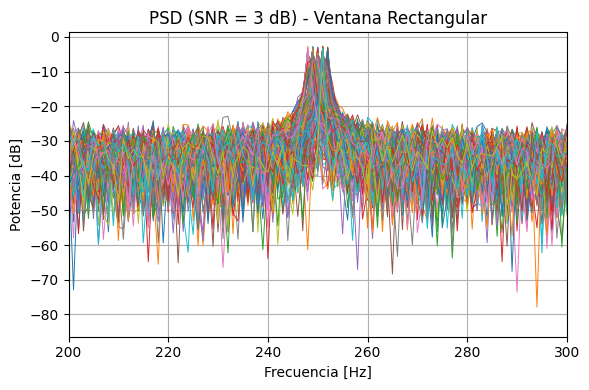

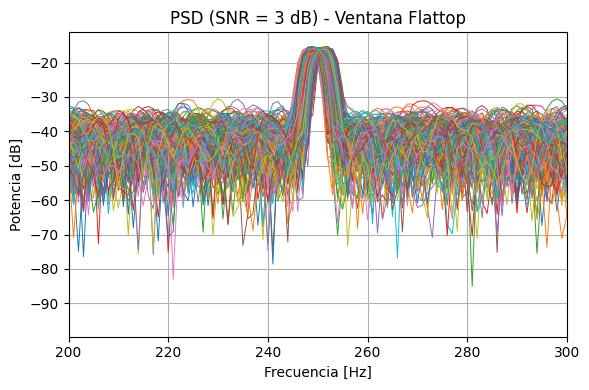

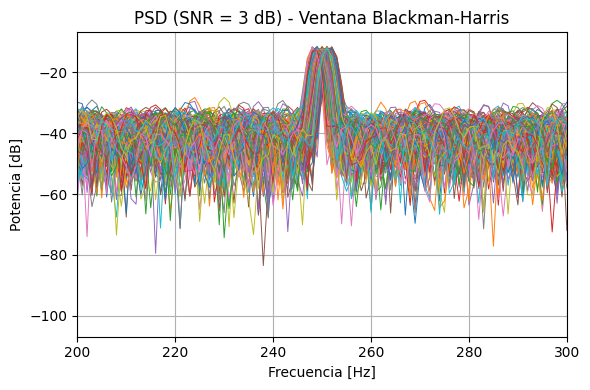

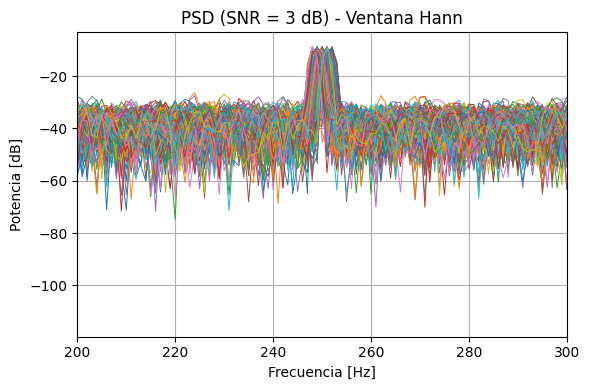

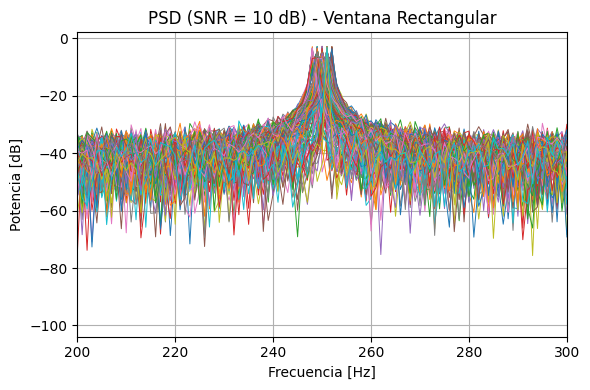

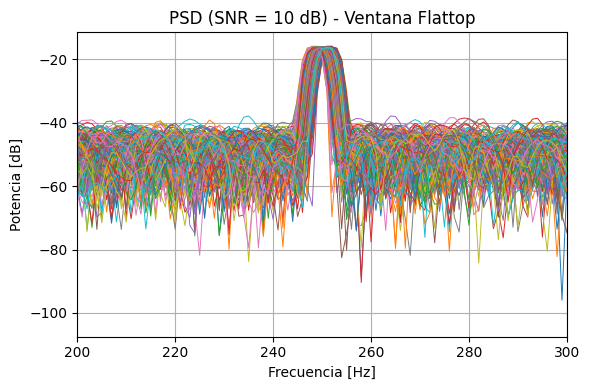

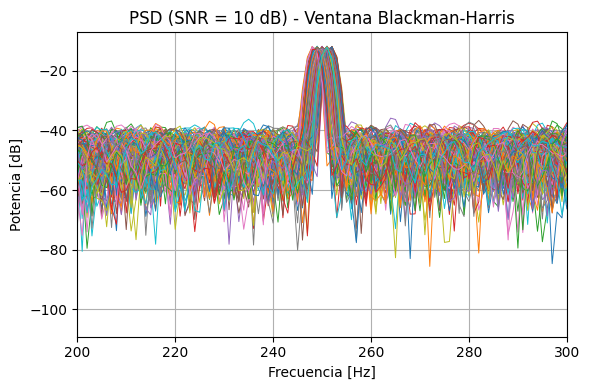

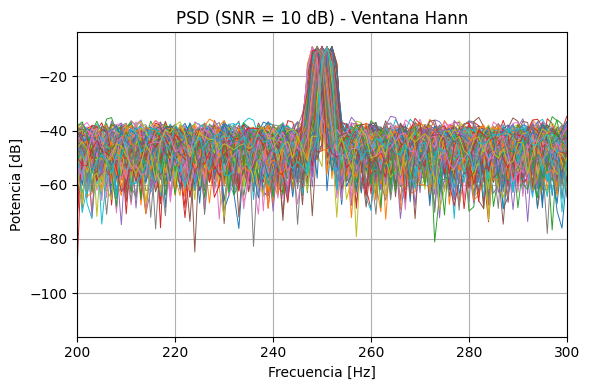

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
import scipy.signal.windows as win

#DEFINICION DE FUNCIONES
def senial(tt, frec, amp, fase=0, vmed=0):
    return amp * np.sin(2 * np.pi * frec * tt + fase) + vmed

def senial_mas_ruido(s, SNR_dB):        
    senial_p = np.mean(s**2)   
    ruido_p = senial_p / (10**(SNR_dB/10))
    ruido = np.random.normal(0, np.sqrt(ruido_p), size=s.shape)
    return s + ruido

#PARÁMETROS DE SIMULACIÓN
N = 1000           #cant de muestras
fs = 1000          #frec de muestreo en Hz
R = 200            #cant de repeticiones
df = fs / N        #resolución espectral
frecuencias = np.arange(N) * df
t = np.arange(N) / fs

#MATRICES 
t_mat = np.tile(t.reshape(N, 1), (1, R))
f_variacion = np.random.uniform(-2, 2, R)
f_base = (N / 4 + f_variacion) * df
f_mat = np.tile(f_base.reshape(1, R), (N, 1))

#GENERO SEÑALES
A_real = np.sqrt(2)
x = senial(t_mat, f_mat, A_real)
x_SNR_BAJO = senial_mas_ruido(x,SNR_dB=3)
x_SNR_ALTO = senial_mas_ruido(x,SNR_dB=10)

#VENTANAS Y FFT
ventanas = {
    "Rectangular": np.ones((N, 1)),
    "Flattop": win.flattop(N, sym=False).reshape(-1, 1),
    "Blackman-Harris": win.blackmanharris(N, sym=False).reshape(-1, 1),
    "Hann": win.hann(N, sym=False).reshape(-1, 1)
}

def calcular_fft(x, ventana):
    return (1/N) * fft(x * ventana, axis=0)

fft_bajo = {}
fft_alto = {}

for nombre, vent in ventanas.items():
    fft_bajo[nombre] = calcular_fft(x_SNR_BAJO, vent)
    fft_alto[nombre] = calcular_fft(x_SNR_ALTO, vent)

#ESTIMACIÓN DE AMPLITUD
def estimar_amp(X, ventana, f_objetivo, fs):
    idx = (f_objetivo * N / fs).astype(int)
    cg = np.sum(ventana) / N                 
    return 2 * np.abs(X[idx, np.arange(X.shape[1])]) / cg

amplitudes_bajo = {}
amplitudes_alto = {}

for nombre in fft_bajo.keys():
    amplitudes_bajo[nombre] = estimar_amp(fft_bajo[nombre], ventanas[nombre], f_base, fs)
for nombre in fft_alto.keys():  
    amplitudes_alto[nombre] = estimar_amp(fft_alto[nombre], ventanas[nombre], f_base, fs)

#SESGO Y VARIANZA
def obtener_metricas(amplitudes, A_teorica):
    sesgo = np.mean(amplitudes) - A_teorica
    varianza = np.var(amplitudes)
    return sesgo, varianza

metricas_bajo = {}
metricas_alto = {}

for nombre in amplitudes_bajo.keys():
    metricas_bajo[nombre] = obtener_metricas(amplitudes_bajo[nombre], A_real)

for nombre in amplitudes_alto.keys():
    metricas_alto[nombre] = obtener_metricas(amplitudes_alto[nombre], A_real)
  
#ESTIMADOR DE FRECUENCIA
def estimar_frec(X, fs, f_base):
    N = X.shape[0]                              
    indices = np.argmax(np.abs(X[:N//2, :]), axis=0)
    frecs_est = indices * fs / N
    sesgo = np.mean(frecs_est - f_base)
    varianza = np.var(frecs_est)
    return sesgo, varianza

frec_bajo = {}
for k, v in fft_bajo.items():
    frec_bajo[k] = estimar_frec(v, fs, f_base)

frec_alto = {}
for k, v in fft_alto.items():
    frec_alto[k] = estimar_frec(v, fs, f_base)

#TABLAS DE RESULTADOS
print("\nResultados (SNR = 3 dB) - Estimación de AMPLITUD")
print(f"{'Ventana':<22} | {'Sesgo [V]':>12} | {'Varianza [V²]':>15}")
print("-" * 55)
for nombre, (sesgo, varianza) in metricas_bajo.items():
    print(f"{nombre:<22} | {sesgo:>12.6f} | {varianza:>15.8f}")

print("\nResultados (SNR = 10 dB) - Estimación de AMPLITUD")
print(f"{'Ventana':<22} | {'Sesgo [V]':>12} | {'Varianza [V²]':>15}")
print("-" * 55)
for nombre, (sesgo, varianza) in metricas_alto.items():
    print(f"{nombre:<22} | {sesgo:>12.6f} | {varianza:>15.8f}")

print("\nResultados (SNR = 3 dB) - Estimación de FRECUENCIA")
print(f"{'Ventana':<22} | {'Sesgo [Hz]':>12} | {'Varianza [Hz²]':>15}")
print("-" * 55)
for nombre, (sesgo, varianza) in frec_bajo.items():
    print(f"{nombre:<22} | {sesgo:>12.6f} | {varianza:>15.8f}")

print("\nResultados (SNR = 10 dB) - Estimación de FRECUENCIA")
print(f"{'Ventana':<22} | {'Sesgo [Hz]':>12} | {'Varianza [Hz²]':>15}")
print("-" * 55)
for nombre, (sesgo, varianza) in frec_alto.items():
    print(f"{nombre:<22} | {sesgo:>12.6f} | {varianza:>15.8f}")


#GRÁFICOS DE PSD
f_central = (N / 4) * df
margen = 50  

# PSD para SNR bajo
for nombre, X in fft_bajo.items():
    plt.figure(figsize=(6, 4))
    plt.plot(frecuencias, 10 * np.log10(np.abs(X)**2), lw=0.7)
    plt.title(f"PSD (SNR = 3 dB) - Ventana {nombre}")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Potencia [dB]")
    plt.xlim(f_central - margen, f_central + margen)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# PSD para SNR alto
for nombre, X in fft_alto.items():
    plt.figure(figsize=(6, 4))
    plt.plot(frecuencias, 10 * np.log10(np.abs(X)**2), lw=0.7)
    plt.title(f"PSD (SNR = 10 dB) - Ventana {nombre}")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Potencia [dB]")
    plt.xlim(f_central - margen, f_central + margen)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Análisis de resultados

**Estimación de amplitud**
La ventana rectangular, como era de esperarse, presenta mayor sesgo y varianza lo cual implica una estimación inestable y un leakage fuerte.
La flattop es la que logra el mejor desempeño, ya que poosee el menor sesgo y varianza. Es coherente ya que es un tipo de ventana que fue diseñada para mejorar la precisión en la estimación de amplitud. 
La Blackman-Harris y la Hann muestran un comportamiento intermedio, ambas reducen considerablemente el leakage respecto a la rectangular pero a costa de un pequeño aumento de sesgo. La Blackman-Harris logra un mejor compromiso entre sesgo y varianza, mientras que la Hann al tener lóbulos laterales más atenuados presenta un poco más de dispersión.
Comparando los dos niveles de ruido, se observa que a aumentar el SNR disminuye la varianza, sobre todo en flattop y Blackman-Harris, mientras que el sesgo permanece casi constante.

**Estimador de frecuencia**
Los resultados muestran que, al igual que con la amplitud, la elección de la ventana influye en el desempeño del estimador. Para ambos niveles de SNR, los valores de sesgo se mantienen extremadamente pequeños (menores a 0,1Hz), lo que indica una estimación prácticamente insesgada para todas las ventanas. En la varianza aparecen diferencias más notorias, aunque son del mismo orden para todos los casos y para varias realizaciones del código, reflejando una buena estabilidad en la estimación. En general, la Blackman–Harris y la Hann presentan un buen equilibrio entre sesgo y varianza, mientras que la Flattop tiende a mostrar un pequeño sesgo positivo, especialmente a 10 dB.

## Conclusión 
Los resultados numéricos del sesgo y la varianza dejan en evidencia como el buen desempeño de un estimador depende de la ventana utilizada. Tanto en el SNR de 3dB como en el de 10dB se puede ver un mismo patrón de comportamiento.
La ventana rectangular prrobó ser la menos adecuada debido a su alto leakage y gran dispersión, mientras que la Flattop logró la mejor precisión en la estimación de amplitud. Las ventanas Blackman–Harris y Hann muestran un compromiso adecuado entre sesgo y varianza, ya que mejoran la estabilidad de los estimadores sin sacrificar demasiada resolución.

En la estimación de frecuencia, todas las ventanas presentan sesgos despreciables y varianzas del mismo orden, lo que demuestra que el método es robusto frente al ruido. 

En conjunto, los resultados determinan que la elección de la ventana es crucial para optimizar la estimación espectral, especialmente en la medición de amplitud bajo condiciones ruidosas.


Con respecto a nuestra experiencia personal resolvimos este trabajo con bastantes dudas, ya la complejidad del código fue un considerablemente mayor. Si bien los conceptos teóricos quedaron bastante claros al trabajarlos en clase, se utilizó inteligencia artificial, específicamente deep seek, para unir fragmentos de los códigos de clase y lograr que tengan coherencia. Por otro lado la inteligencia artificial se utilizó para explicaciones de operadores específicos de scipy o numpy, formateo de ecuaciones para insertar en jupyter notebook, correcciones sobre la función de estimador de amplitud para ubicar bien el pico y finalmente, para que los gráficos quedaran más agradables al ojo.


